<a href="https://colab.research.google.com/github/johny-ger/labs/blob/main/%D0%93%D0%B5%D1%80%D0%B3%D0%B5%D0%B4%D0%B0%D0%B2%D0%B0_%D0%94_%D0%A0_%D0%9F%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D0%B3%D1%80%D0%B0%D1%84%D0%BE%D0%B2%D1%8B%D1%85_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Загрузка данных
data1 = pd.read_csv('/content/longitudalALL.csv')
data2 = pd.read_csv('/content/longitudalNOTALL.csv')

#data1 = pd.read_csv('/content/only format.csv')
#data2 = pd.read_csv('/content/only 9 columns only format.csv')

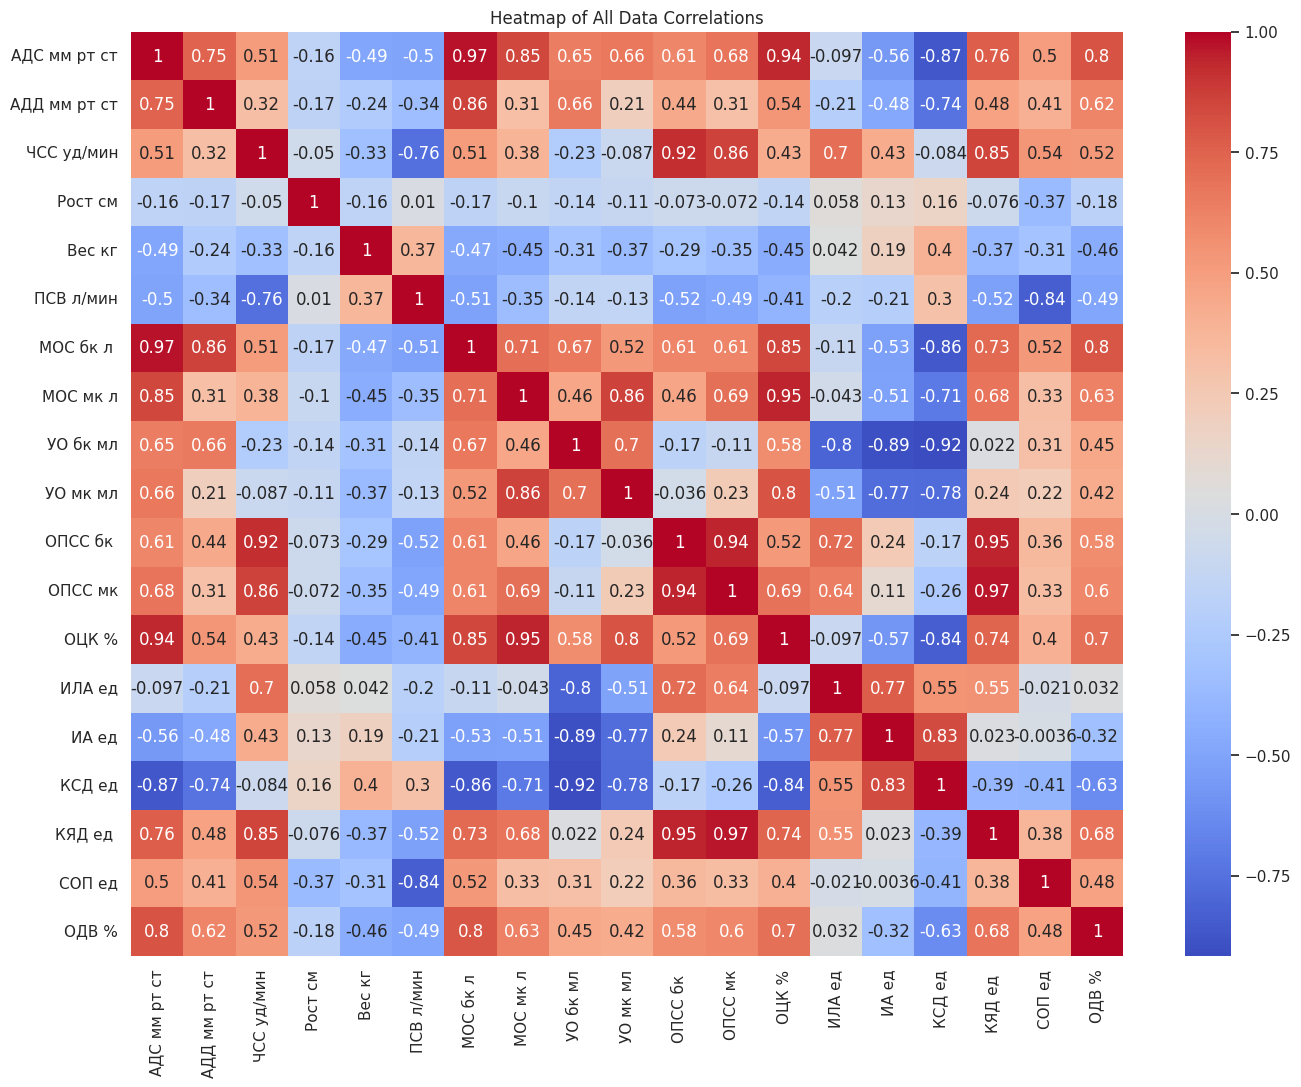

In [ ]:
# Объединение данных
#all_data = pd.concat([data1, data2])

all_data = data1

# Построение корреляционной матрицы
corr_all = all_data.corr()

# Корреляционная матрица
plt.figure(figsize=(16, 12))
sns.heatmap(corr_all, annot=True, cmap='coolwarm')
plt.title('Heatmap of All Data Correlations')
plt.show()

# Создание списка связей из корреляционной матрицы
links = corr_all.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Фильтрация для положительных и отрицательных корреляций
links_positive = links.query("value > 0.20 and var1 != var2")
links_negative = links.query("value < -0.20 and var1 != var2")

In [ ]:
# Создание графов
G_positive = nx.from_pandas_edgelist(links_positive, 'var1', 'var2', edge_attr=True)
G_negative = nx.from_pandas_edgelist(links_negative, 'var1', 'var2', edge_attr=True)

pos_positive = nx.kamada_kawai_layout(G_positive)
pos_negative = nx.kamada_kawai_layout(G_negative)

In [ ]:
def adjust_edge_color(weights, palette):
    color_palette = sns.color_palette(palette, n_colors=256)
    max_weight = max(weights)
    edge_colors = [
        color_palette[min(int(255 * abs(weight/max_weight)**0.5), 255)]
        for weight in weights
    ]
    return edge_colors


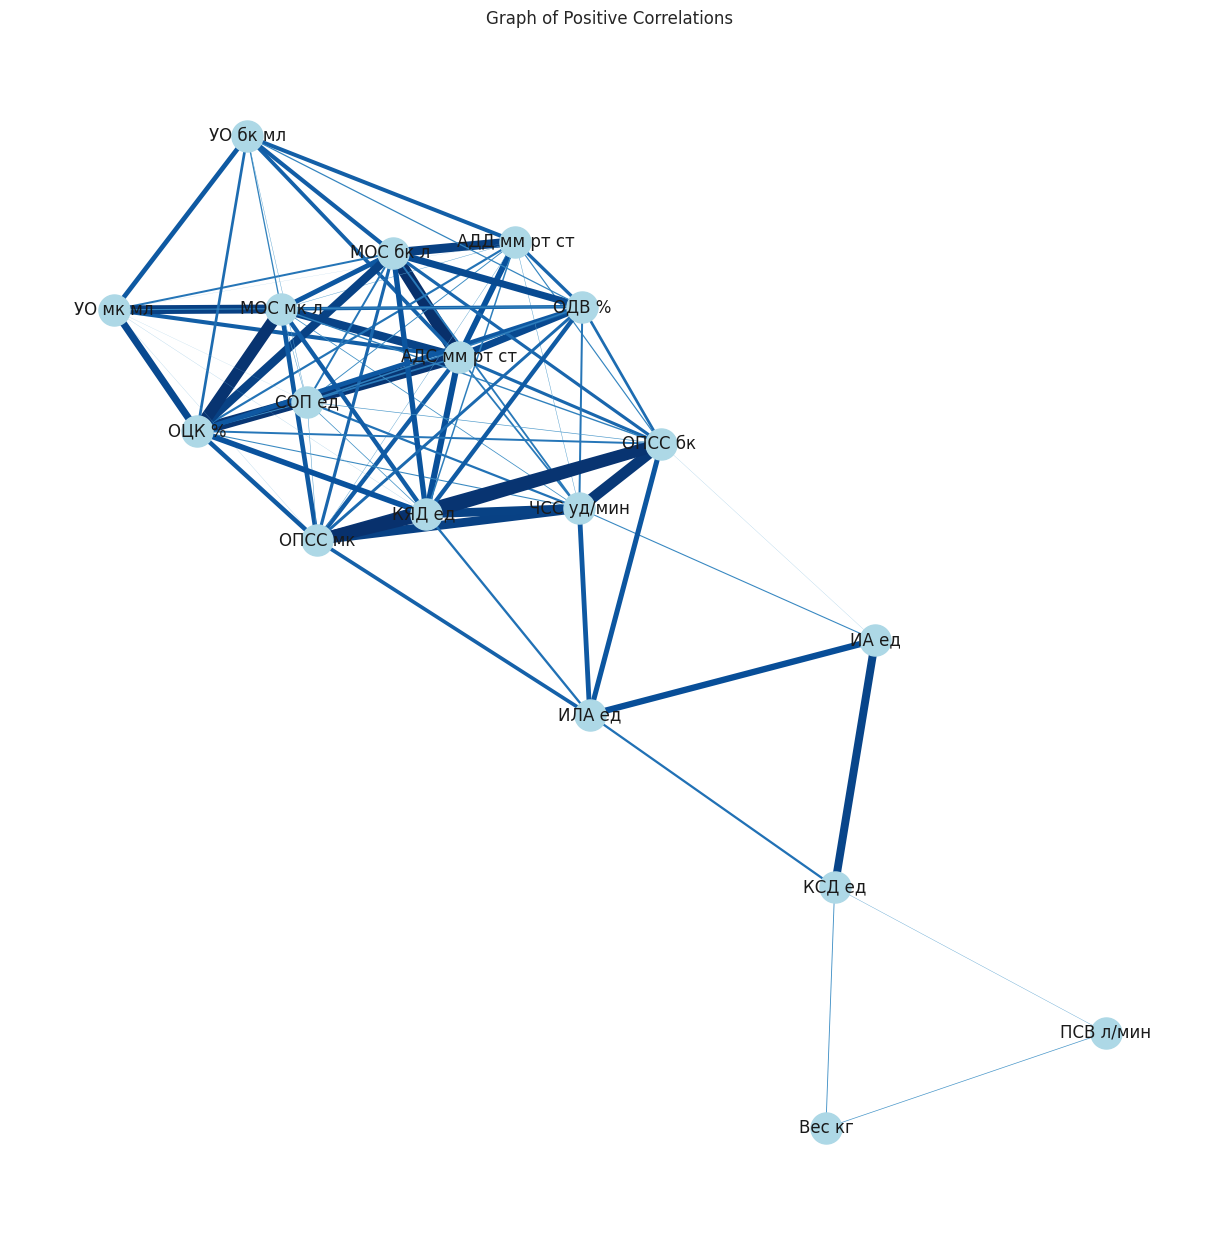

In [ ]:
# Позитивная визуализация
plt.figure(figsize=(12, 12))
edge_weights_positive = [G_positive[u][v]['value'] for u, v in G_positive.edges()]
edge_colors_positive = adjust_edge_color(edge_weights_positive, "Blues")
nx.draw(G_positive, pos_positive, with_labels=True, node_color='lightblue', node_size=500,
        edge_color=edge_colors_positive, width=[abs(w)**3 * 10 for w in edge_weights_positive])
plt.title('Graph of Positive Correlations')
plt.show()

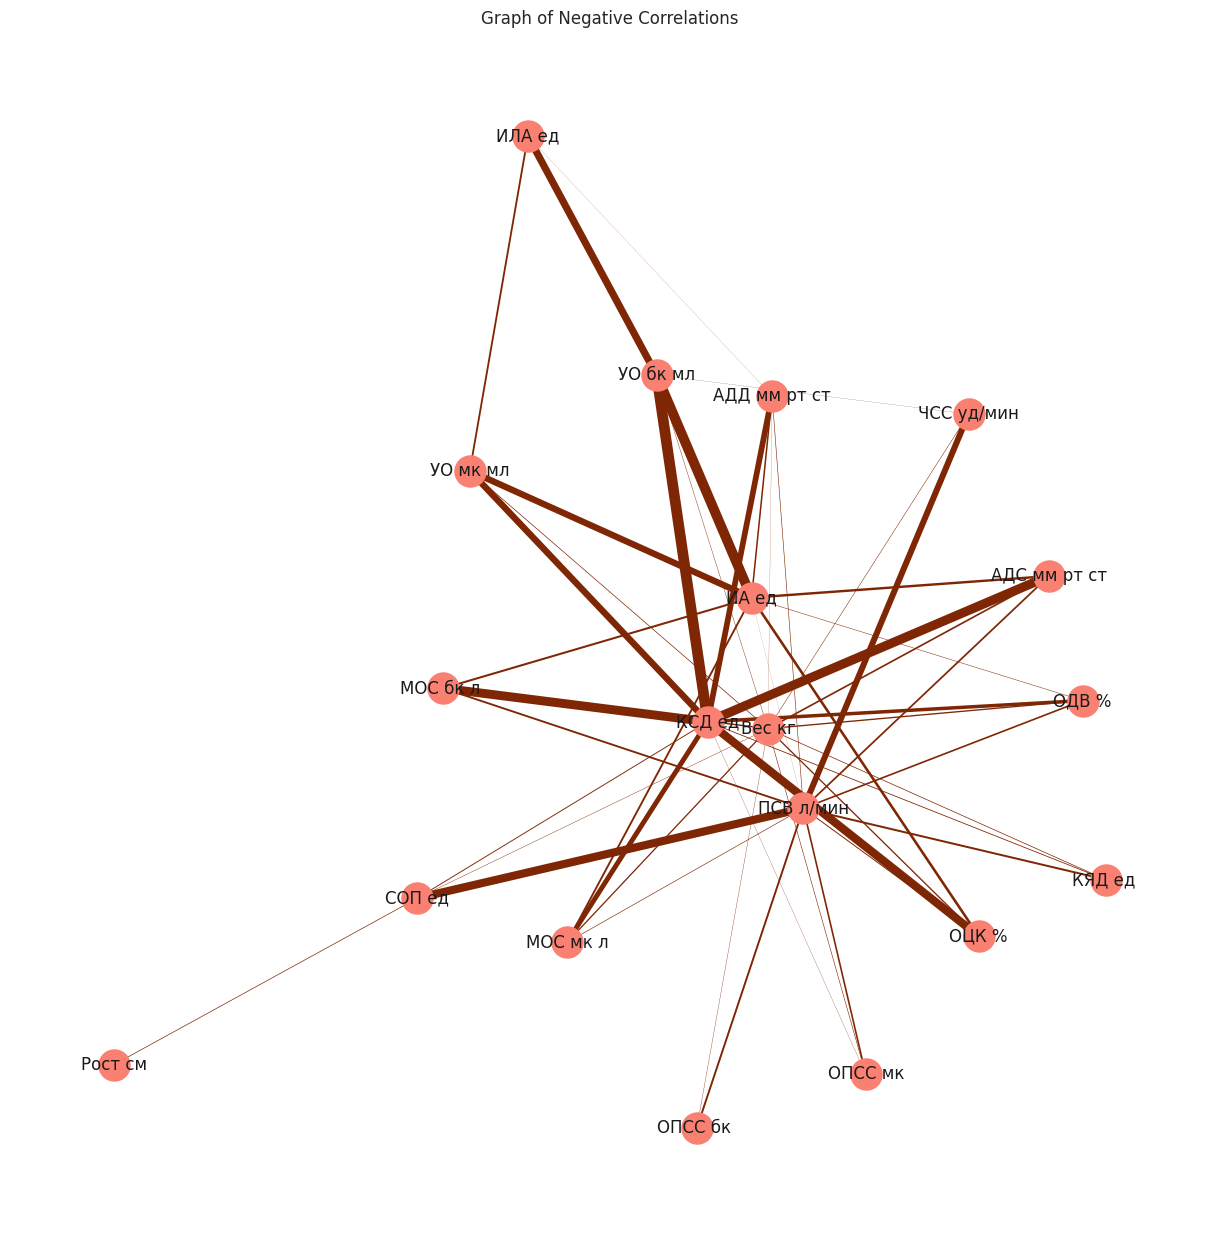

In [ ]:
# Негативные графы
plt.figure(figsize=(12, 12))
edge_weights_negative = [G_negative[u][v]['value'] for u, v in G_negative.edges()]
edge_colors_negative = adjust_edge_color(edge_weights_negative, "Oranges")
nx.draw(G_negative, pos_negative, with_labels=True, node_color='salmon', node_size=500,
        edge_color=edge_colors_negative, width=[abs(w)**3 * 10 for w in edge_weights_negative])
plt.title('Graph of Negative Correlations')
plt.show()

In [ ]:
# Сохранение
GRAPH_TO_TSV = True  # Установите True, если нужно сохранять файлы
DATA_PATH = '/content/'  # Путь к каталогу для сохранения файлов

if GRAPH_TO_TSV:
  links_positive.to_csv(DATA_PATH + 'Graph_plus.tsv', sep='\t', index=False)
  links_negative.to_csv(DATA_PATH + 'Graph_minus.tsv', sep='\t', index=False)

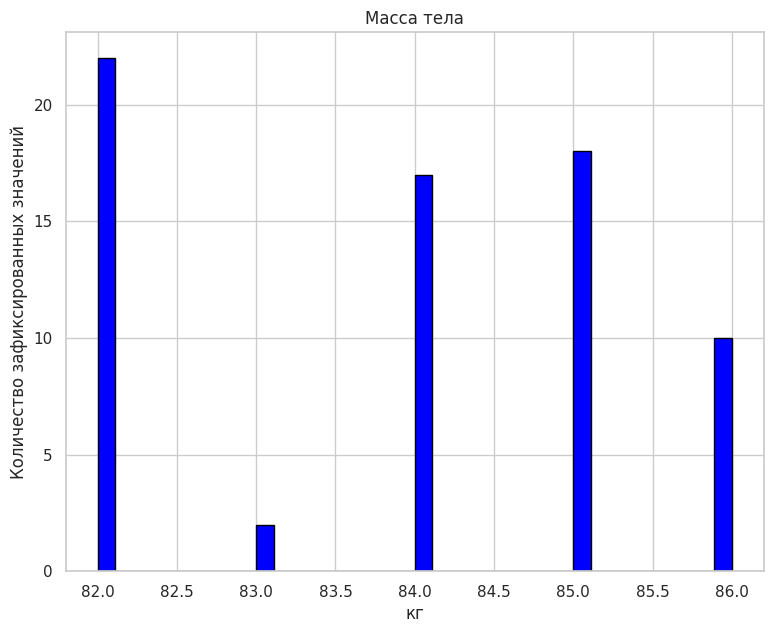

In [ ]:
# Историграм
plt.figure(figsize=(9, 7))
plt.hist(data1['Вес кг'], bins=36, color='blue', edgecolor='black')
plt.title('Масса тела')
plt.xlabel('кг')
plt.ylabel('Количество зафиксированных значений')
plt.show()

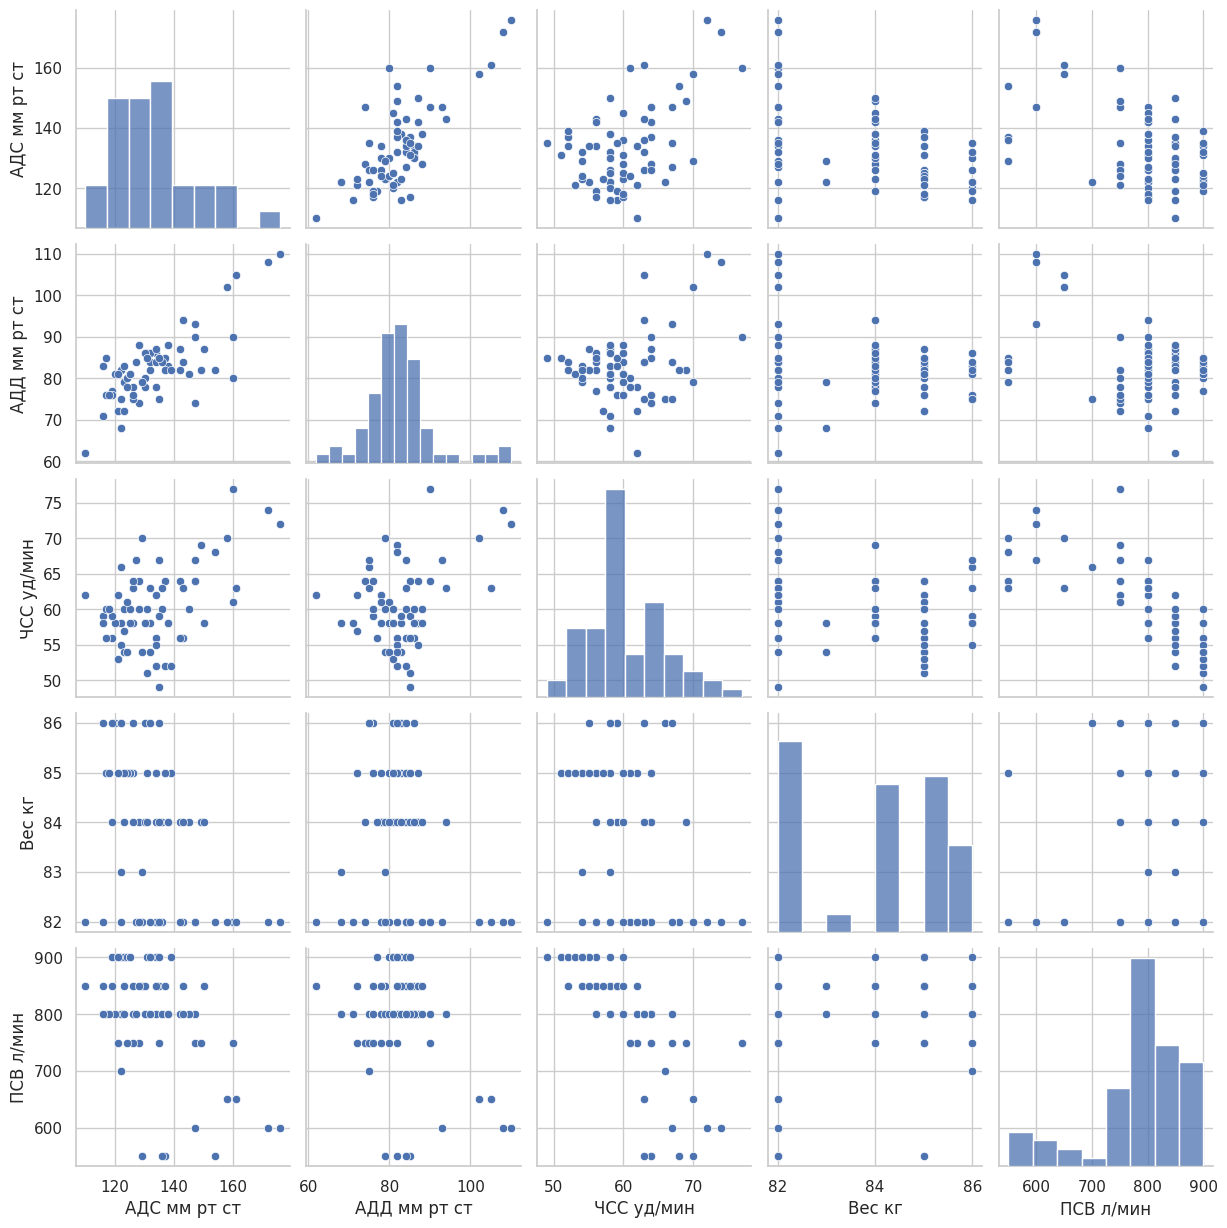

In [ ]:
# Кор. анализ числовых значений
numeric_features = ['АДС мм рт ст', 'АДД мм рт ст', 'ЧСС уд/мин', 'Вес кг', 'ПСВ л/мин']
sns.pairplot(data2[numeric_features])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Detect and remove outliers
def detect_outliers(df, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = list(set(outlier_indices))  # Удаление дубликатов
    return outlier_indices

outliers = detect_outliers(data2, numeric_features)
data2_cleaned = data2.drop(outliers)
print(f'Removed {len(outliers)} outliers')

Removed 10 outliers


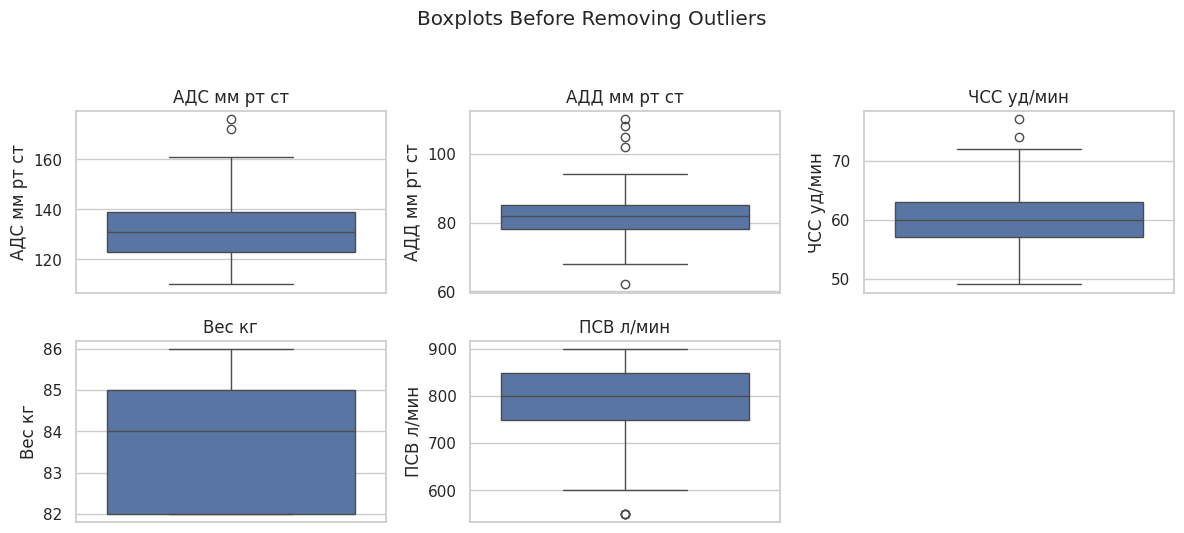

In [ ]:
# Визуализация ящиков с усами до удаления выбросов
plt.figure(figsize=(12, 8))
plt.suptitle('Boxplots Before Removing Outliers')
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=data2[feature])
    plt.title(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

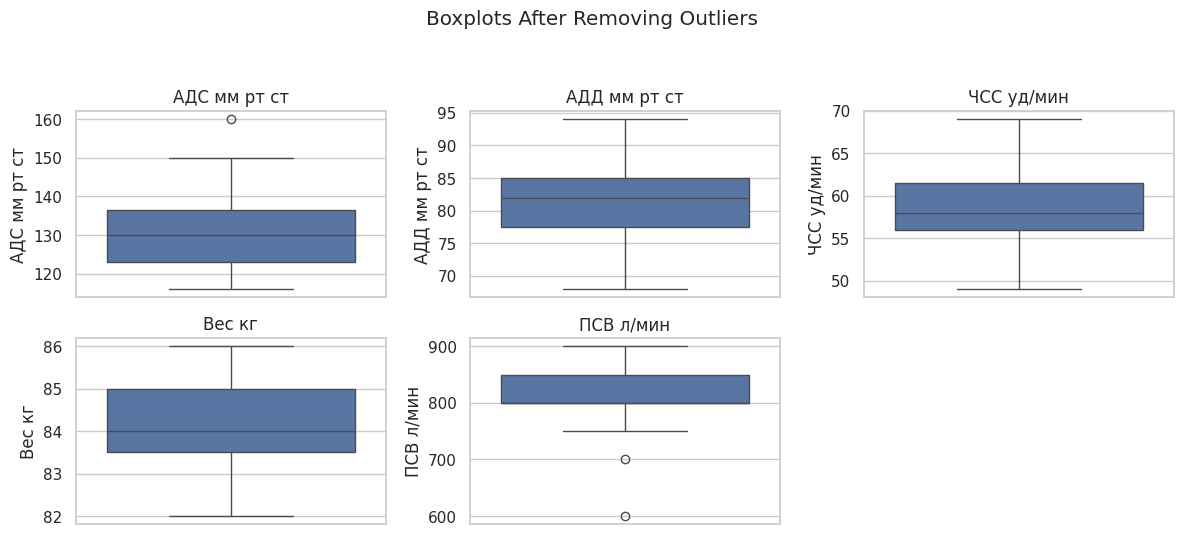

In [ ]:
# Визуализация ящиков с усами после удаления выбросов
plt.figure(figsize=(12, 8))
plt.suptitle('Boxplots After Removing Outliers')
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=data2_cleaned[feature])
    plt.title(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

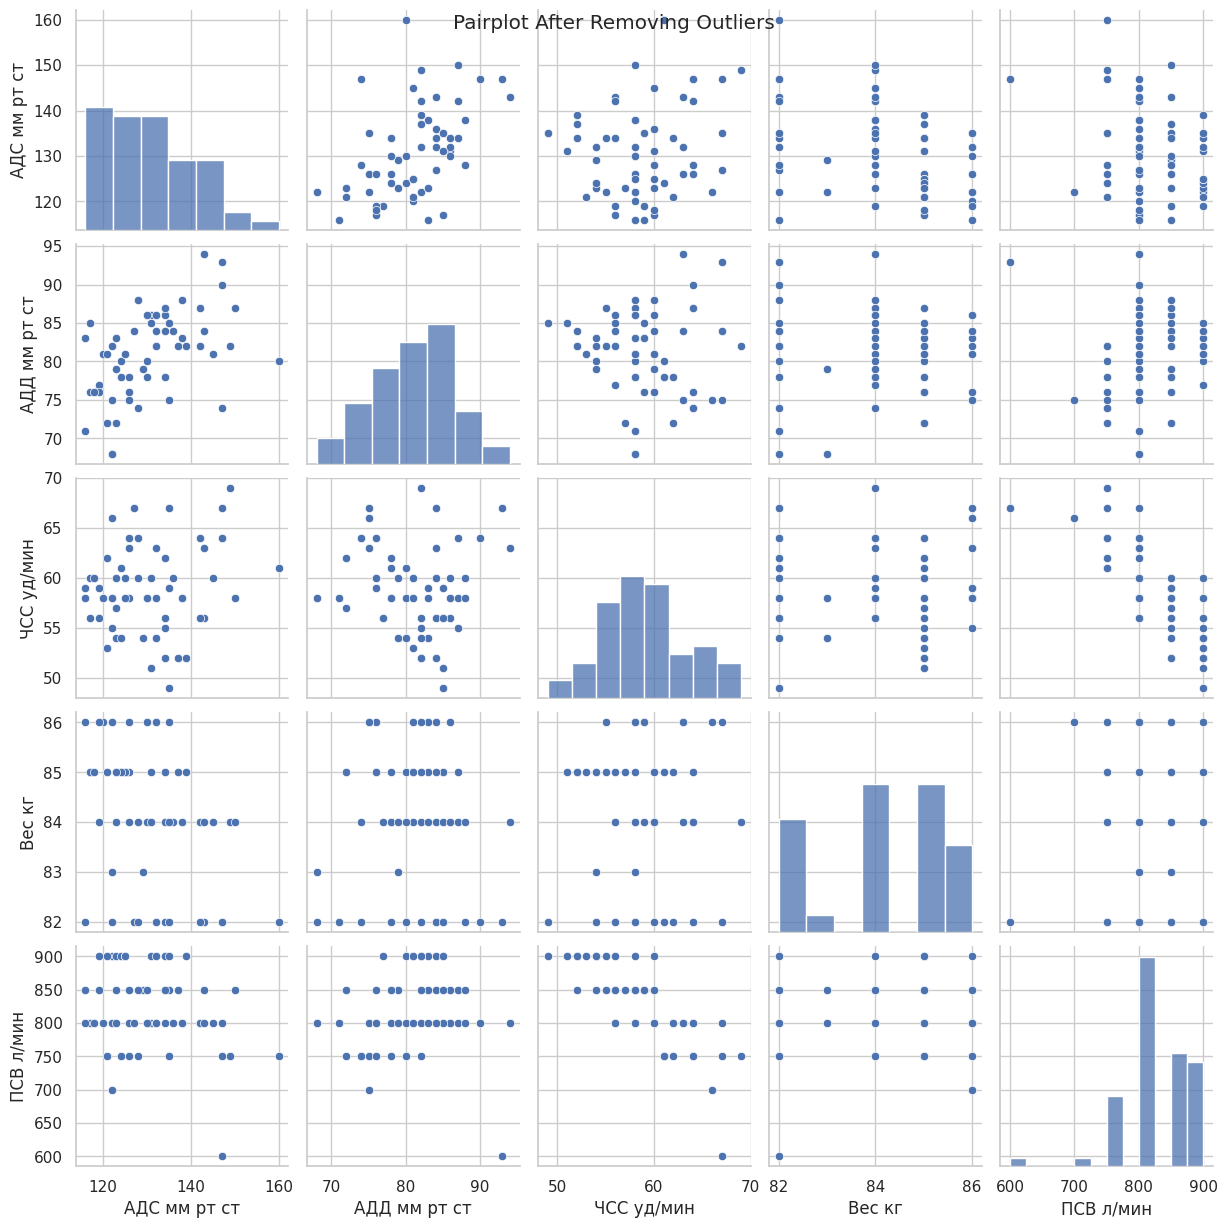

In [ ]:
# Визуализация парных отношений после удаления выбросов
sns.pairplot(data2_cleaned[numeric_features])
plt.suptitle('Pairplot After Removing Outliers')
plt.show()

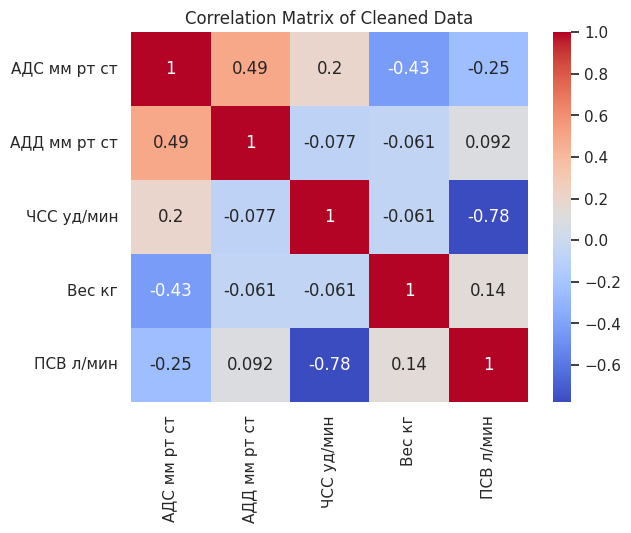

In [ ]:
# Show clean data correlations
sns.heatmap(data2_cleaned[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Cleaned Data')
plt.show()

In [ ]:
import plotly.express as px

# Использование Plotly для интерактивной визуализации данных о возрасте
fig = px.histogram(data1, x='Вес кг', title='Распределение весов')
fig.show()

In [ ]:
import plotly.express as px

# Использование Plotly для интерактивной визуализации данных о возрасте
fig = px.histogram(data1, x='ПСВ л/мин', title='Распределение ПСВ')
fig.show()

In [ ]:
# Загрузка данных
data = pd.read_csv('/content/longitudalNOTALL.csv')

# Создание категорий для веса
data['Вес_группа'] = pd.cut(data['Вес кг'],
                            bins=[82, 83, 84, 85, 86],
                            labels=['82-83', '83-84', '84-85', '85-86'],
                            right=False)

# Создание категорий для ПСВ (пиковой скорости выдоха)
data['ПСВ_группа'] = pd.cut(data['ПСВ л/мин'],
                            bins=[550, 600, 650, 700, 750, 800, 850, 900],
                            labels=['550-600', '600-650', '650-700', '700-750', '750-800', '800-850', '850-900'],
                            right=False)


# Подготовка данных для Sankey диаграммы
source = []
target = []
value = []

# Группировка данных по возрастной группе и росту
for group, group_data in data.groupby(['Вес_группа', 'ПСВ_группа']):
    source.append(group[0])
    target.append(group[1])
    value.append(len(group_data))

# Создание уникальных идентификаторов для узлов
labels = list(set(source + target))
label_indices = {label: i for i, label in enumerate(labels)}

# Построение Sankey диаграммы
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=5,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels
    ),
    link=dict(
        source=[label_indices[src] for src in source],
        target=[label_indices[tgt] for tgt in target],
        value=value
    ))])

fig.update_layout(title_text="Sankey Diagram of Weight Groups to PER Groups", font_size=12)
fig.show()


In [ ]:
# Создание категорий для АДС
data['АДС_группа'] = pd.cut(data['АДС мм рт ст'],
                            bins=[0, 120, 140, 160, 180, 200],
                            labels=['<120', '120-140', '140-160', '160-180', '180+'],
                            right=False)

# Создание категорий для АДД
data['АДД_группа'] = pd.cut(data['АДД мм рт ст'],
                            bins=[0, 80, 90, 100, 110],
                            labels=['<80', '80-90', '90-100', '100+'],
                            right=False)

# Создание категорий для ЧСС
data['ЧСС_группа'] = pd.cut(data['ЧСС уд/мин'],
                            bins=[0, 60, 70, 80, 90, 100],
                            labels=['<60', '60-70', '70-80', '80-90', '90+'],
                            right=False)

# Создание категорий для веса
data['Вес_группа'] = pd.cut(data['Вес кг'],
                            bins=[0, 50, 70, 90, 110, 130],
                            labels=['<50', '50-70', '70-90', '90-110', '110+'],
                            right=False)

# Создание категорий для ПСВ
data['ПСВ_группа'] = pd.cut(data['ПСВ л/мин'],
                            bins=[0, 200, 400, 600, 800, 1000],
                            labels=['<200', '200-400', '400-600', '600-800', '800+'],
                            right=False)

# Для подготовки данных к Sankey диаграмме
sources = []
targets = []
values = []

# Последовательное сопоставление категорий
connections = [
    ('АДС_группа', 'АДД_группа'),
    ('АДД_группа', 'ЧСС_группа'),
    ('ЧСС_группа', 'Вес_группа'),
    ('Вес_группа', 'ПСВ_группа')
]

# Сопоставление каждой группы с последующей в цепочке
for src, tgt in connections:
    group_data = data.groupby([src, tgt]).size().reset_index(name='count')
    for _, row in group_data.iterrows():
        sources.append(f'{row[src]} ({src})')
        targets.append(f'{row[tgt]} ({tgt})')
        values.append(row['count'])
# Создание уникальных идентификаторов для узлов
unique_nodes = list(set(sources + targets))
node_indices = {node: i for i, node in enumerate(unique_nodes)}

# Построение Sankey диаграммы
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=unique_nodes
    ),
    link=dict(
        source=[node_indices[src] for src in sources],
        target=[node_indices[tgt] for tgt in targets],
        value=values
    ))])

fig.update_layout(title_text="Sankey Diagram of Patient Data", font_size=12)
fig.show()